# 纽约市出租车行程预测
## 一、数据处理
### 1.1 数据来源
除了给定的出租车数据，在网上还找到了一下数据集：
- [出租车行程数据集](https://www.kaggle.com/datasets/yasserh/nyc-taxi-trip-duration)
- [2016年纽约市天气数据](https://www.kaggle.com/datasets/cabaki/knycmetars2016?resource=download)
- [2016年纽约市节假日数据](https://www.kaggle.com/datasets/pceccon/nyc2016holidays)
- [2016年纽约市1KM分辨率人口](https://hub.worldpop.org/geodata/summary?id=80022)



In [44]:
# taxi_travel_time_prediction.ipynb
import pandas as pd
import numpy as np
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
import optuna
import optuna.integration.lightgbm as oplgb

import warnings
warnings.filterwarnings('ignore')

### 1.2读取数据集

In [45]:
# 1.读取训练和预测集
# 参数parse_dates可以解析日期格式
data_df = pd.read_csv('../实习二数据/train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])
# 划分训练集，测试集和验证集（0.7 0.2 0.1）
train_df, test_df, valid_df = np.split(data_df, [int(len(data_df) * 0.7), int(len(data_df) * 0.9)])
# 删除data_df，释放内存
del data_df
dfs = [train_df, test_df, valid_df]

# 显示数据集的前1行
print(dfs[0].shape, dfs[1].shape)
print("训练集和测试集的前1行数据：")
print(dfs[0].head(1))
print(dfs[1].head(1))

# 2.读取节假日数据
holiday = pd.read_csv('../实习二数据/NYC_2016Holidays.csv', sep=';', parse_dates=['Date'])
# 将假期数据转换为与数据集一致的datetime格式
holiday['Date'] = holiday['Date'].apply(lambda x: x + ' 2016')
holidays = [datetime.strptime(holiday.loc[i, 'Date'], '%B %d %Y').date() for i in range(len(holiday))]
holidays[:3]

# 3.读取天气数据
# 读取天气数据
weather = pd.read_csv('../实习二数据/KNYC_Metars.csv', parse_dates=['Time'])
print("天气数据集前一行：")
print(weather.head(1))

(1021050, 11) (291729, 11)
训练集和测试集的前1行数据：
          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1            -73.98            40.77             -73.96   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0             40.77                  N            455  
                id  vendor_id     pickup_datetime    dropoff_datetime  \
1021050  id1319211          2 2016-04-28 17:41:35 2016-04-28 17:50:53   

         passenger_count  pickup_longitude  pickup_latitude  \
1021050                5            -74.01            40.71   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
1021050             -74.01             40.72                  N            558  
天气数据集前一行：
                 Time  Temp.  Windchill  Heat Index  Humidity  Pressure  \
0 2015-12-31 02:00:00   7.80       7.

## 二、数据清洗

缺失值检查：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021050 entries, 0 to 1021049
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1021050 non-null  object        
 1   vendor_id           1021050 non-null  int64         
 2   pickup_datetime     1021050 non-null  datetime64[ns]
 3   dropoff_datetime    1021050 non-null  datetime64[ns]
 4   passenger_count     1021050 non-null  int64         
 5   pickup_longitude    1021050 non-null  float64       
 6   pickup_latitude     1021050 non-null  float64       
 7   dropoff_longitude   1021050 non-null  float64       
 8   dropoff_latitude    1021050 non-null  float64       
 9   store_and_fwd_flag  1021050 non-null  object        
 10  trip_duration       1021050 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 85.7+ MB
描述性统计：
       vendor_id                picku

<Axes: ylabel='trip_duration'>

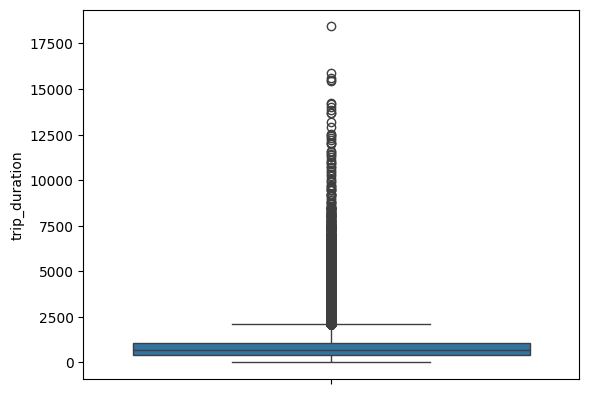

In [46]:
# 1.检查缺失值
print("缺失值检查：")
dfs[0].info() # 根据输出未发现缺失值

# 2.异常值
# 2.1 描述型统计
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("描述性统计：")
print(dfs[0].describe())# 查看描述性统计，发现有不合理的值

# 2.2 passenger_count异常值处理
print("训练集和测试集的passenger_count各种取值数量：")
print(dfs[0].passenger_count.value_counts())
print(dfs[1].passenger_count.value_counts())
for i in range(len(dfs)):
    # TODO: 不如直接删除，以及更优秀的异常值发现方法
    dfs[i]['passenger_count'].replace({
            0:1,7:6,8:6,9:6},inplace=True) # 采用最邻近替换掉异常值0，7，8，9

# 2.3 trip_duration异常值处理
# 查看trip_duration的均值、标准差
time_mean = np.mean(dfs[0].trip_duration)
time_std = np.std(dfs[0].trip_duration)
print(time_mean, time_std)
# 删除异常值
dfs[0] = dfs[0][(dfs[0]['trip_duration']<=(time_mean + 3 * time_std)) & (dfs[0]['trip_duration']>=(time_mean - 3 * time_std))]
# 用正态删除了最大的异常值，但没有删除最小的异常值
# TODO: 最小异常值这样处理还是太简单了
dfs[0] = dfs[0][dfs[0]['trip_duration']!=1]
sns.boxplot(dfs[0]['trip_duration'])# 查看去除异常值后的trip_duration分布

## 三、特征工程与EDA
### 3.1 时间特征

- 由上面的分析可以发现，trip_duration的标准差为5237.43，说明行程时间数据差异大，为减小数据差异带来的干扰，将数据log化：log_trip_duration
- 提取时间特征
- 是否是工作日、节假日
- 将时段分为早晚高峰、白天、夜晚

log_trip_duration分布：


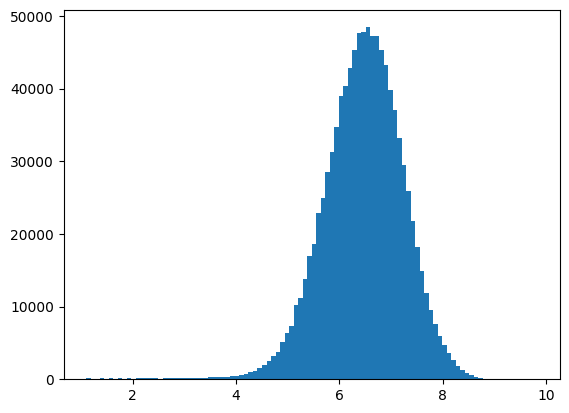

In [47]:
# 3.1 log_trip_duration取对数
dfs[0]['log_trip_duration'] = np.log(dfs[0]['trip_duration'].values + 1)
print("log_trip_duration分布：")
plt.hist(dfs[0]['log_trip_duration'].values, bins=100)
plt.show()

# 3.2 提取时间特征
# 提取年、月、日、小时、分钟、星期、日期
for i, d in enumerate(dfs):
    dfs[i]['year'] = d.pickup_datetime.dt.year
    dfs[i]['month'] = d.pickup_datetime.dt.month
    dfs[i]['day'] = d.pickup_datetime.dt.day
    dfs[i]['hour'] = d.pickup_datetime.dt.hour
    dfs[i]['minute'] = d.pickup_datetime.dt.minute
    dfs[i]['dayofweek'] = d.pickup_datetime.dt.dayofweek
    dfs[i]['date'] = d.pickup_datetime.dt.date
    dfs[i]['time'] = d.hour + d.minute/60

# 判断是否工作日、是否节假日
for i, d in enumerate(dfs):
    dfs[i]['is_weekend'] = d['dayofweek'].apply(lambda x: 1 if x==5 or x==6 else 0)
    dfs[i]['is_rest'] = d['date'].apply(lambda x: 1 if x in holidays else 0)

# 24小时切分为不同时段：早高峰、晚高峰、白天、夜晚
def get_time_interval(series):
    hour = series['hour']
    is_rest = series['is_rest']
    
    if is_rest==1:
        if hour>=7 and hour<=21:
            time_interval='day'
        elif hour>21 or hour<7:
            time_interval='night'
    elif is_rest==0:
        if hour>=7 and hour<=9: 
            time_interval='morning_peak'
        elif hour>=17 and hour<=21:
            time_interval='evening_peak'
        elif hour>9 and hour<17:
            time_interval='day'
        elif hour>21 or hour<7:
            time_interval='night'
    return time_interval

for i, d in enumerate(dfs):
    dfs[i]['time_interval'] = d.apply(get_time_interval, axis=1)



### 3.2 天气特征  

In [48]:
# 3.3 天气特征
print("各类天气数量：")
print(weather.Events.value_counts())
# 将天气加上时间标签：
# 提取天气特征的年月日等时间特征，并筛选年份天气等特征。
weather['year'] = weather.Time.dt.year
weather['month'] = weather.Time.dt.month
weather['day'] = weather.Time.dt.day
weather['hour'] = weather.Time.dt.hour
weather['events_weather'] = weather['Events'].apply(lambda x: 0 if x=='None' else 1)
weather = weather[weather['year']==2016][['Temp.', 'Visibility', 'events_weather', 'month', 'day','hour', 'Precip']]
# 与上车时间合并
for i, d in enumerate(dfs):
    dfs[i] = pd.merge(d, weather, on=['month', 'day', 'hour'], how='left')

各类天气数量：
Events
Rain              377
Snow               51
Fog\n\t,\nSnow     23
Fog                 2
Fog\n\t,\nRain      2
Name: count, dtype: int64


### 3.3 距离特征

In [49]:
# 计算经纬度之间的距离
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return round(c * 6371, 3) # 地球平均半径，6371km

# 单位：km
for i, d in enumerate(dfs):
    dfs[i]['haversine'] = d.apply(lambda x: haversine(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

### 3.4 区域特征
- 对经纬度用kmeans聚类，创建区域特征分为15个类别：(感觉不太好)
数据集太大，所以用MiniBatchKMeans代替，能够对小规模子集进行计算，减少计算时间。
- 对经纬度用PCA，创建新特征

#### 3.4.1 增加投影坐标系

In [50]:
from pyproj import Transformer

# 定义坐标转换器（WGS84→UTM18N，纽约适用）
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32618", always_xy=True)

# 为每个数据集添加上下车投影坐标
for df in dfs:
    # 上车点投影坐标
    df['pickup_x'], df['pickup_y'] = transformer.transform(
        df['pickup_longitude'].values, 
        df['pickup_latitude'].values
    )
    # 下车点投影坐标
    df['dropoff_x'], df['dropoff_y'] = transformer.transform(
        df['dropoff_longitude'].values, 
        df['dropoff_latitude'].values
    )

#### 3.4.2 坐标聚类与主成分分析

In [51]:

# 先将所有需要转换的数据汇总，一起放入fit

coords = np.vstack((dfs[0][['pickup_x', 'pickup_y']].values,
                    dfs[0][['dropoff_x', 'dropoff_y']].values))
# 随机采样
sample_ids = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(init='k-means++', n_clusters=15, batch_size=10000).fit(coords[sample_ids])

# 聚类
for i, d in enumerate(dfs):
    dfs[i]['pickup_cluster'] = kmeans.predict(d[['pickup_x', 'pickup_y']])
    dfs[i]['dropoff_cluster'] = kmeans.predict(d[['dropoff_x', 'dropoff_y']])

print(pd.concat([dfs[0], dfs[1]]).groupby(['pickup_cluster']).size().reset_index())

# PCA
pca = PCA().fit(coords)
for i, d in enumerate(dfs):
    dfs[i]['pickup_pca0'] = pca.transform(d[['pickup_x', 'pickup_y']])[:, 0]
    dfs[i]['pickup_pca1'] = pca.transform(d[['pickup_x', 'pickup_y']])[:, 1]
    dfs[i]['dropoff_pca0'] = pca.transform(d[['dropoff_x', 'dropoff_y']])[:, 0]
    dfs[i]['dropoff_pca1'] = pca.transform(d[['dropoff_x', 'dropoff_y']])[:, 1]

    pickup_cluster       0
0                0   76027
1                1  121440
2                2   29814
3                3  130971
4                4   37299
5                5  173634
6                6   70183
7                7   90864
8                8    1368
9                9   14100
10              10  107057
11              11  114230
12              12  186914
13              13  134448
14              14   22959


### 3.5 速度
- 根据haversine距离与trip_duration计算车速：speed=haversine(km)×1000/trip_duration，单位m/s
- 由于test无法计算haversine speed，所以根据haversine speed计算每个区域的平均速度

#### 3.5.1 Voronoi 图划分
- 因为不知道测试集和验证集的行驶时间，所以无法计算速度，为了使用速度特征，根据上面的聚类结果，进行Voronoi 图划分，利用训练集，计算每一个区域划分的平均速度

- 计算区域剖分里的平均速度

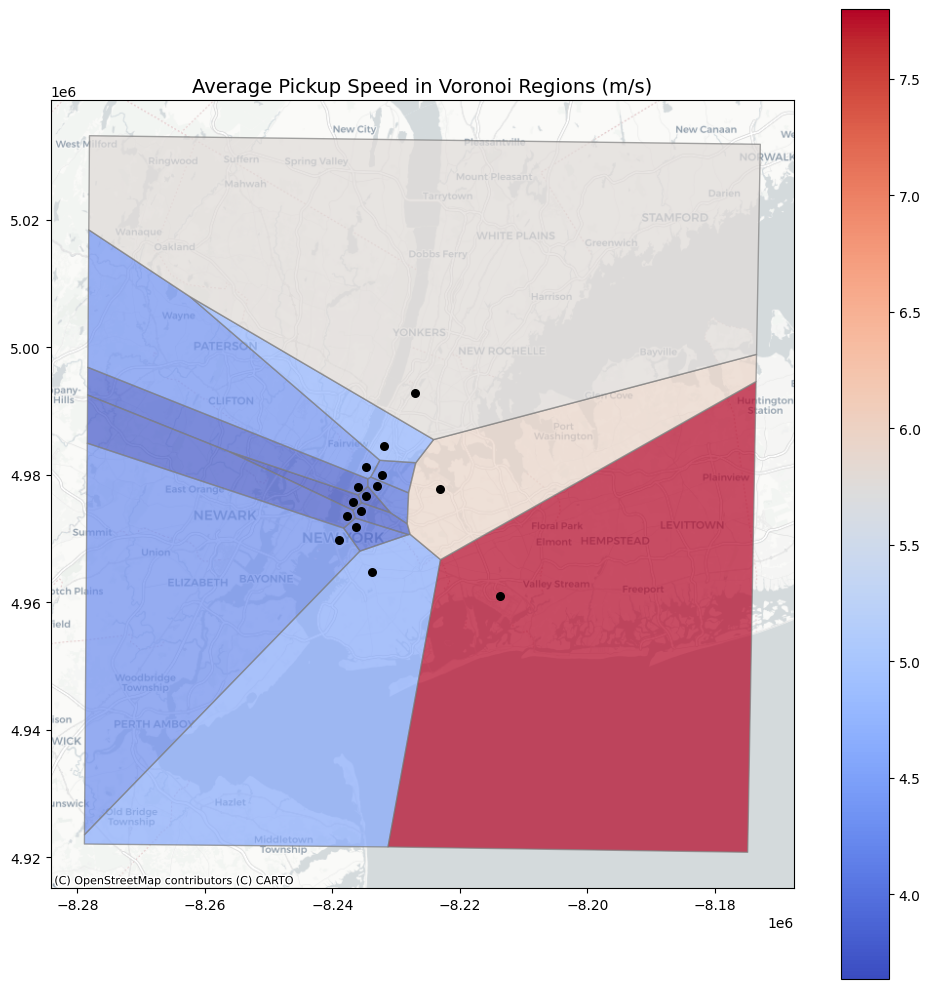

In [52]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import voronoi_diagram
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gc

# ========= 1. 基于 KMeans 聚类中心构建 Voronoi 区域 =========
centers = kmeans.cluster_centers_
# centers shape: (n_clusters, 2) -> order is (x, y) i.e. (pickup_x, pickup_y)
points = gpd.GeoSeries([Point(x, y) for x, y in centers], crs="EPSG:32618")

# 使用 union_all()（替代 unary_union）构建 envelope 并生成 Voronoi
# buffer 的大小按城市尺度调整（这里 30km）
multi = points.union_all()
envelope = multi.buffer(30000)  
vor = voronoi_diagram(multi, envelope=envelope)
vor_polygons = list(vor.geoms)

vor_gdf = gpd.GeoDataFrame({
    'region_id': range(len(vor_polygons)),
    'geometry': vor_polygons
}, crs="EPSG:32618")

# ========= 2. 计算训练集速度（m/s）并清理异常值 =========
train = dfs[0].copy()
# 假定 haversine 是以 km 为单位，trip_duration 单位为秒
train['speed'] = train['haversine'] * 1000 / train['trip_duration']
train = train.loc[train['speed'].between(0.1, 50)].reset_index(drop=True)

# ========= 3. 计算 pickup 区域平均速度 =========
pickup_gdf = gpd.GeoDataFrame(
    train[['pickup_x', 'pickup_y', 'speed']].copy(),
    geometry=gpd.points_from_xy(train['pickup_x'], train['pickup_y']),
    crs="EPSG:32618"
)
# 空间连接：每个点落在哪个 voronoi polygon 内
pickup_join = gpd.sjoin(pickup_gdf, vor_gdf[['region_id', 'geometry']], how='left', predicate='within')

pickup_speed = (
    pickup_join.groupby('region_id')['speed']
    .mean()
    .reset_index()
    .rename(columns={'speed': 'avg_pickup_speed'})
)

# ========= 4. 计算 dropoff 区域平均速度 =========
drop_gdf = gpd.GeoDataFrame(
    train[['dropoff_x', 'dropoff_y', 'speed']].copy(),
    geometry=gpd.points_from_xy(train['dropoff_x'], train['dropoff_y']),
    crs="EPSG:32618"
)
drop_join = gpd.sjoin(drop_gdf, vor_gdf[['region_id', 'geometry']], how='left', predicate='within')

drop_speed = (
    drop_join.groupby('region_id')['speed']
    .mean()
    .reset_index()
    .rename(columns={'speed': 'avg_dropoff_speed'})
)

# ========= 5. 合并速度回 Voronoi 区域 =========
vor_gdf = vor_gdf.merge(pickup_speed, on='region_id', how='left')
vor_gdf = vor_gdf.merge(drop_speed, on='region_id', how='left')

# 计算全局回退值（若某些 region 没有样本）
global_avg_pick = vor_gdf['avg_pickup_speed'].mean(skipna=True)
global_avg_drop = vor_gdf['avg_dropoff_speed'].mean(skipna=True)

# 用全局均值填充 Voronoi 中的 NaN （避免以后映射到 NaN）
vor_gdf['avg_pickup_speed'] = vor_gdf['avg_pickup_speed'].fillna(global_avg_pick)
vor_gdf['avg_dropoff_speed'] = vor_gdf['avg_dropoff_speed'].fillna(global_avg_drop)

# ========= 6. 为 dfs 中每个 DataFrame 添加特征（不删除任何 dfs） =========
# 说明：为了保持原始 df 行顺序，我们在 sjoin 后根据原索引把特征写回
for idx, df in enumerate(dfs):
    # 上车特征
    gdf_pick = gpd.GeoDataFrame(
        df[['pickup_x', 'pickup_y']].copy(),
        geometry=gpd.points_from_xy(df['pickup_x'], df['pickup_y']),
        crs="EPSG:32618"
    )
    joined_pick = gpd.sjoin(gdf_pick, vor_gdf[['region_id', 'avg_pickup_speed', 'geometry']],
                            how='left', predicate='within')
    # joined_pick 保持与 gdf_pick 相同的 index（通常为原 df index），但以防万一，reindex到原 df.index
    joined_pick = joined_pick.reindex(df.index)
    # 若有缺失，再回退为全局平均
    pick_vals = joined_pick['avg_pickup_speed'].fillna(global_avg_pick).to_numpy()
    df['avg_pickup_speed'] = pick_vals

    # 下车特征
    gdf_drop = gpd.GeoDataFrame(
        df[['dropoff_x', 'dropoff_y']].copy(),
        geometry=gpd.points_from_xy(df['dropoff_x'], df['dropoff_y']),
        crs="EPSG:32618"
    )
    joined_drop = gpd.sjoin(gdf_drop, vor_gdf[['region_id', 'avg_dropoff_speed', 'geometry']],
                            how='left', predicate='within')
    joined_drop = joined_drop.reindex(df.index)
    drop_vals = joined_drop['avg_dropoff_speed'].fillna(global_avg_drop).to_numpy()
    df['avg_dropoff_speed'] = drop_vals

    # 删除临时 geometry 列（保持原 df 结构）
    # 注意我们在修改 dfs 中的 df（原地修改），因此不需要赋值回 dfs
    if 'geometry' in df.columns:
        df.drop(columns='geometry', inplace=True)

# ========= 7. 释放中间变量以节省内存（可选） =========
del pickup_gdf, drop_gdf, pickup_join, drop_join, pickup_speed, drop_speed, train, gdf_pick, gdf_drop, joined_pick, joined_drop
gc.collect()

# ========= 8. 可视化：绘制 Voronoi 区域 + 底图（显示 avg_pickup_speed） =========
try:
    import contextily as ctx
    vor_gdf_web = vor_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10))
    vor_gdf_web.plot(
        ax=ax,
        column='avg_pickup_speed',
        cmap='coolwarm',
        legend=True,
        edgecolor='gray',
        alpha=0.7
    )
    # 把聚类中心点也画到地图上（转换到 web mercator）
    centers_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:32618").to_crs(epsg=3857)
    centers_gdf.plot(ax=ax, color='black', markersize=30, label='KMeans Centers')

    ctx.add_basemap(ax, crs=vor_gdf_web.crs, source=ctx.providers.CartoDB.Positron)
    ax.set_title("Average Pickup Speed in Voronoi Regions (m/s)", fontsize=14)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("可视化（带底图）未能执行，原因：", e)
    print("你可以通过 pip install contextily 来启用底图支持；或仅使用 vor_gdf.plot(...) 查看矢量图。")


### 3.6 人口特征


In [53]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.transform import rowcol

# --------------------------
# 1. 核心函数：根据经纬度提取人口密度
# --------------------------
def get_population_density(tif_path, lon, lat):
    """通用函数：根据经纬度（lon, lat）提取对应位置的人口密度"""
    with rasterio.open(tif_path) as src:
        # 经纬度转TIF行列索引
        rows, cols = rowcol(src.transform, lon, lat)
        
        # 索引边界处理
        rows = np.clip(rows, 0, src.height - 1)
        cols = np.clip(cols, 0, src.width - 1)
        
        # 读取人口密度（假设第1波段为密度值）
        pop_density = src.read(1)[rows, cols]
        
        # 处理无效值（NoData）
        nodata = src.nodata if src.nodata is not None else -9999
        pop_density = np.where(pop_density == nodata, np.nan, pop_density)
        
        # 用整体平均值填充缺失
        mean_density = np.nanmean(pop_density)
        return np.nan_to_num(pop_density, nan=mean_density)

# --------------------------
# 2. 添加上车点+下车点人口密度特征
# --------------------------
# 替换为你的NYC人口TIF路径
NYC_POP_TIF = "../实习二数据/nyc_population_2016.tif"  # 例如："nyc_pop_raster.tif"

# 遍历所有数据框（train/test）
for i in range(len(dfs)):
    # 1. 上车点人口密度
    pickup_lon = dfs[i]['pickup_longitude'].values
    pickup_lat = dfs[i]['pickup_latitude'].values
    dfs[i]['pickup_pop_density'] = get_population_density(NYC_POP_TIF, pickup_lon, pickup_lat)
    
    # 2. 下车点人口密度
    dropoff_lon = dfs[i]['dropoff_longitude'].values
    dropoff_lat = dfs[i]['dropoff_latitude'].values
    dfs[i]['dropoff_pop_density'] = get_population_density(NYC_POP_TIF, dropoff_lon, dropoff_lat)

# --------------------------
# 3. 检查结果
# --------------------------
print("添加上下车点人口密度后的前5行数据：")
print(dfs[0][[
    'id', 'pickup_longitude', 'pickup_latitude', 'pickup_pop_density',
    'dropoff_longitude', 'dropoff_latitude', 'dropoff_pop_density',
    'trip_duration'
]].head())

添加上下车点人口密度后的前5行数据：
          id  pickup_longitude  pickup_latitude  pickup_pop_density  \
0  id2875421            -73.98            40.77            11674.00   
1  id2377394            -73.98            40.74            32831.08   
2  id3858529            -73.98            40.76            10337.24   
3  id3504673            -74.01            40.72             9841.03   
4  id2181028            -73.97            40.79            36603.33   

   dropoff_longitude  dropoff_latitude  dropoff_pop_density  trip_duration  
0             -73.96             40.77             29462.14            455  
1             -74.00             40.73             20344.47            663  
2             -74.01             40.71             15132.38           2124  
3             -74.01             40.71              8950.64            429  
4             -73.97             40.78               969.62            435  


### 3.7 分类变量转换
- store_and_fwd_flag、time_interval，进行dummy操作

In [54]:
for i, d in enumerate(dfs):
    store_and_fwd_flag_dummy = pd.get_dummies(d.store_and_fwd_flag, prefix='sff', prefix_sep='_')
    time_interval_dummy = pd.get_dummies(d.time_interval, prefix='ti', prefix_sep='_')

    dfs[i] = pd.concat([d, store_and_fwd_flag_dummy, time_interval_dummy], axis = 1)

## 四、探索性分析

In [55]:
# TODO: 探索性分析

## 五、建模

In [56]:
# 5.1.1 指定特征
features = ['vendor_id', 'passenger_count', 'pickup_longitude', 
            'pickup_latitude', 'dropoff_longitude', 
            'dropoff_latitude', 'month', 'day', 'hour', 
            'minute', 'dayofweek', 'time', 'is_weekend', 
            'is_rest', 'Temp.', 'Visibility', 
            'events_weather', 'Precip', 'haversine', 
            'pickup_cluster', 'dropoff_cluster', 
            'avg_pickup_speed', 'avg_dropoff_speed', 'sff_N', 
            'sff_Y', 'ti_day', 'ti_morning_peak', 'ti_night', 'ti_evening_peak', 'pickup_pca0', 'pickup_pca1',
            'dropoff_pca0', 'dropoff_pca1','pickup_pop_density','dropoff_pop_density']

# 划分数据集
RANDOM_SEED = 42
train_X = dfs[0][features]
train_y = dfs[0]['trip_duration']
val_X = dfs[1][features]
val_y = dfs[1]['trip_duration']
test_df_X = dfs[2][features]
test_y = dfs[2]['trip_duration']


### 5.2 评价指标

In [57]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))

### 5.3LightGBM模型训练

#### 5.3.1 超参数最优化

In [ ]:
from lightgbm import early_stopping, LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import numpy as np

# 假设你已定义 RANDOM_SEED、train_X、val_X、rmsle 等变量

def objective(trial):
    param = {
        'random_state': RANDOM_SEED, 
        'n_estimators': 1000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20, 50]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)      
    }
    
    lgb = LGBMRegressor(**param)
    lgb.fit(
        train_X, train_y,
        eval_set=[(val_X, val_y)],
        callbacks=[early_stopping(stopping_rounds=20,verbose=False)]
    )
    pred_lgb = lgb.predict(val_X)
    return rmsle(val_y, pred_lgb)

# 执行超参数搜索
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Best trial:', study.best_trial.params)
print("------------------------------------------------")
print(study.trials_dataframe())



[I 2025-10-23 15:21:09,763] A new study created in memory with name: no-name-d7403311-e19e-4130-b3e7-8d9ed0d215ea


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3298
[LightGBM] [Info] Number of data points in the train set: 1019579, number of used features: 35
[LightGBM] [Info] Start training from score 837.059307


#### 5.3.2 模型训练

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping

# --------------------------
# 1. 你的原有训练代码（不变）
# --------------------------
best_model = LGBMRegressor(** study.best_trial.params)
best_model.fit(
    train_X, train_y,
    eval_set=[(train_X, train_y), (val_X, val_y)],  # 新增：同时记录训练集损失（方便对比）
    eval_metric="rmse",  # 明确评估指标（如RMSE，与你任务一致）
    callbacks=[early_stopping(stopping_rounds=20, verbose=True)]  # verbose=True 打印迭代日志
)

# --------------------------
# 2. 提取训练过程的损失数据
# --------------------------
# evals_result_ 结构：key是数据集名称（如"validation_0"对应train_X，"validation_1"对应val_X）
# value是字典，key是评估指标（如"rmse"），value是每次迭代的损失值列表
evals_result = best_model.evals_result_
train_loss = evals_result["validation_0"]["rmse"]  # 训练集RMSE
val_loss = evals_result["validation_1"]["rmse"]    # 验证集RMSE
iterations = range(1, len(train_loss) + 1)         # 迭代次数（从1开始）

# --------------------------
# 3. 绘制训练过程曲线
# --------------------------
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')

# 绘制训练集/验证集损失曲线
plt.plot(iterations, train_loss, label=f'Train RMSE', color='royalblue', linewidth=2)
plt.plot(iterations, val_loss, label=f'Val RMSE', color='darkorange', linewidth=2, linestyle='--')

# 标记早停位置
if hasattr(best_model, 'best_iteration_'):
    best_iter = best_model.best_iteration_  # 最优迭代次数
    best_val_loss = val_loss[best_iter - 1]  # 最优迭代对应的验证集损失
    plt.scatter(best_iter, best_val_loss, color='red', s=80, zorder=5, label=f'Best Iteration ({best_iter})')
    plt.axvline(x=best_iter, color='red', linestyle=':', alpha=0.7, label=f'Early Stopping Line')

# 图表美化
plt.xlabel('Iteration Number', fontsize=12)
plt.ylabel('RMSE (Root Mean Squared Error)', fontsize=12)
plt.title('LightGBM Training Process: RMSE vs Iterations', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 1165230, number of used features: 35
[LightGBM] [Info] Start training from score 6.460303
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.149882


,boosting_type,'gbdt'
,num_leaves,986
,max_depth,17
,learning_rate,0.02
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,98


### 5.4 模型分析

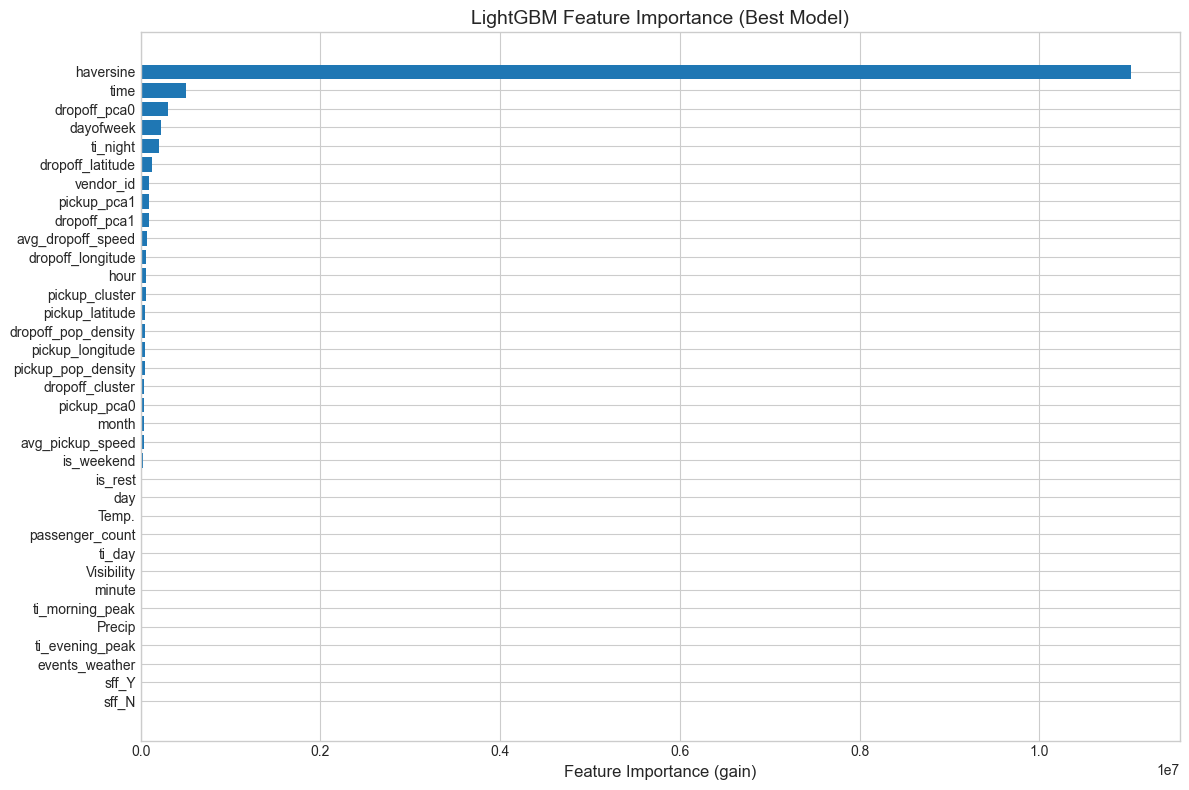

In [ ]:
# 5.4.1 特征重要性可视化
# 获取特征名称（假设train_X是DataFrame，若为numpy数组可手动指定特征名）
feature_names = train_X.columns if hasattr(train_X, 'columns') else [f'feature_{i}' for i in range(train_X.shape[1])]

# 获取特征重要性（兼容sklearn接口的LightGBM）
importance_type = 'gain'  # 'split'表示分裂次数，'gain'表示总增益（更推荐）
# 关键修正：通过booster_获取底层模型，调用feature_importance方法
feature_importance = best_model.booster_.feature_importance(importance_type=importance_type)

# 排序特征重要性
sorted_idx = np.argsort(feature_importance)[::-1]  # 从高到低排序
sorted_importance = feature_importance[sorted_idx]
sorted_names = [feature_names[i] for i in sorted_idx]

# 绘制特征重要性条形图
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
plt.yticks(range(len(sorted_importance)), sorted_names, fontsize=10)
plt.xlabel(f'Feature Importance ({importance_type})', fontsize=12)
plt.title('LightGBM Feature Importance (Best Model)', fontsize=14)
plt.gca().invert_yaxis()  # 让最重要的特征在顶部
plt.tight_layout()  # 调整布局避免文字截断
plt.show()

验证集预测结果（原始时间单位，前5行）：
   真实时间（秒）  预测时间（秒）  绝对误差（秒）  相对误差
0   815.00   627.24   187.76  0.23
1   499.00   552.23    53.23  0.11
2  1351.00   873.67   477.33  0.35
3  1642.00  1099.16   542.84  0.33
4   236.00   220.26    15.74  0.07

【原始时间单位评估指标】（核心关注）
平均绝对时间差距：204.23 秒
均方根时间差距：354.46 秒
平均相对误差：32.38%
------------------------------------------------------------
【log尺度评估指标】（模型拟合参考）
log尺度RMSE：0.3871
log尺度R²：0.7490



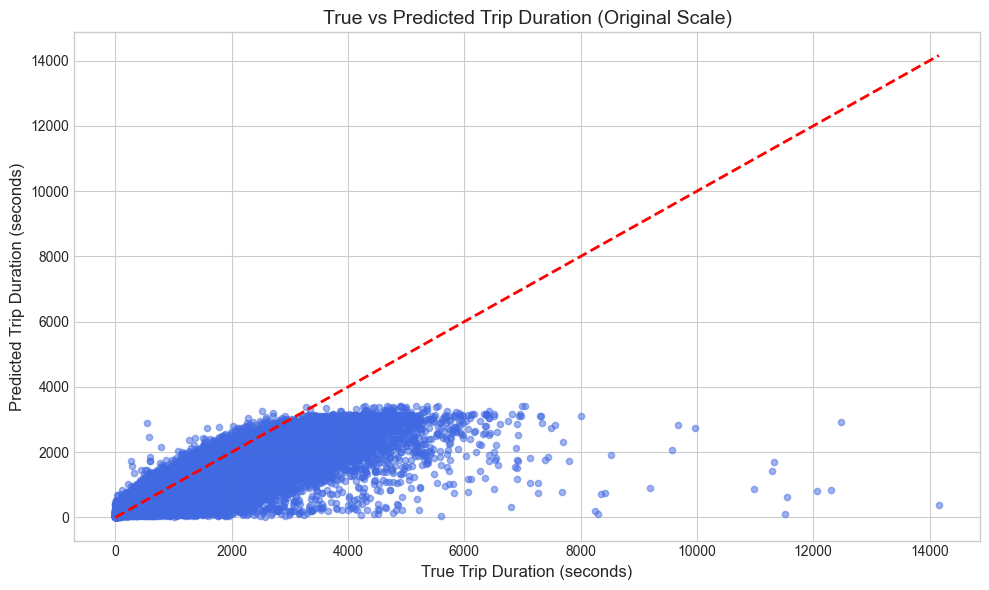

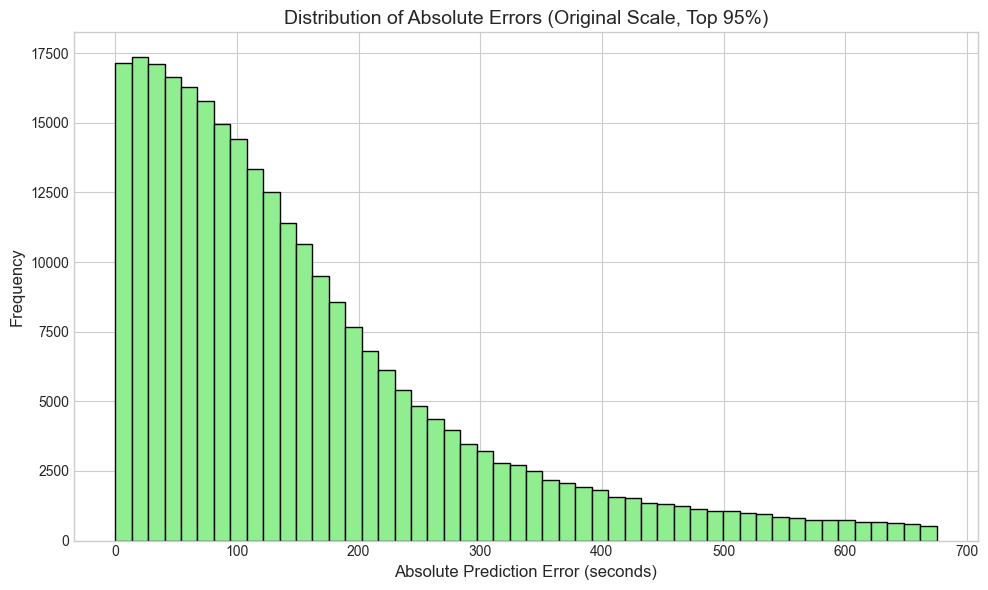

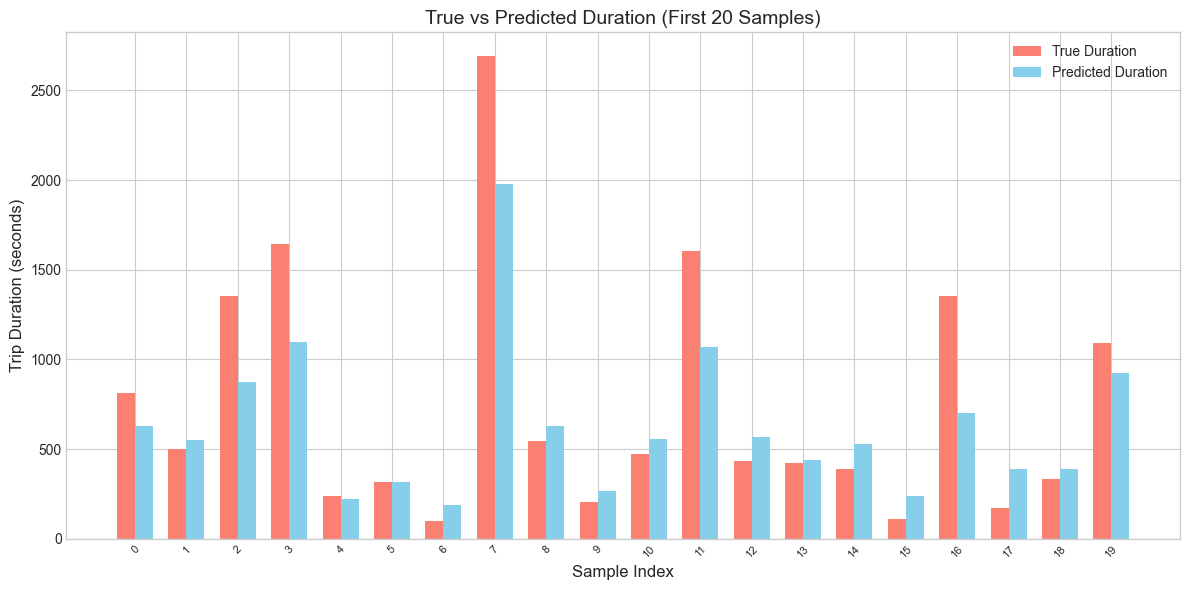

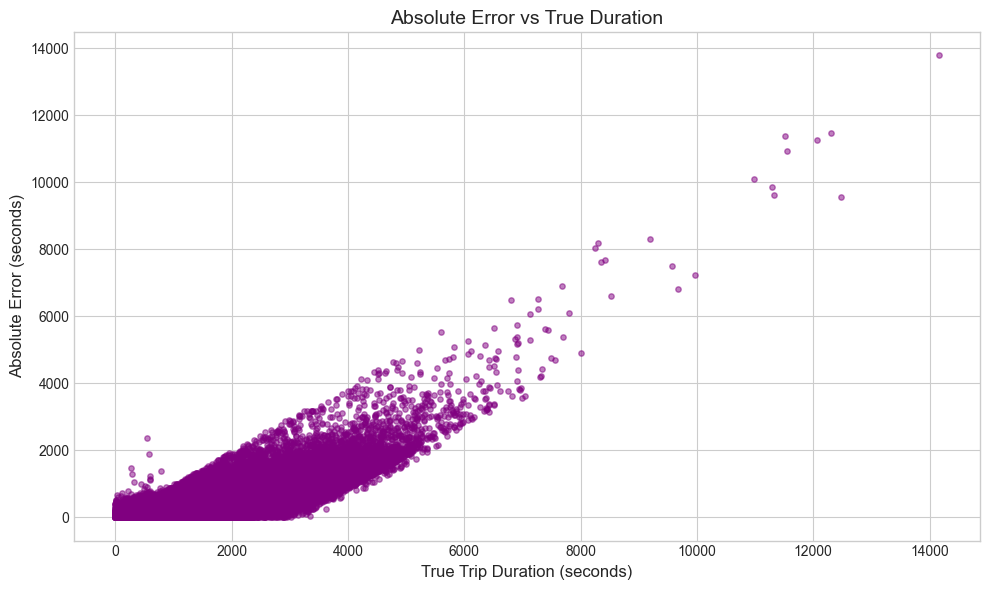


误差最大的10个样本（原始时间单位）：
        真实时间（秒）  预测时间（秒）  绝对误差（秒）  相对误差
108161 14160.00   371.44 13788.56  0.97
68410  12313.00   831.42 11481.58  0.93
123068 11513.00   115.01 11397.99  0.99
256599 12064.00   798.23 11265.77  0.93
208187 11556.00   626.67 10929.33  0.95
1878   10981.00   870.22 10110.78  0.92
117816 11295.00  1438.79  9856.21  0.87
194128 11332.00  1694.98  9637.02  0.85
84315  12480.00  2914.30  9565.70  0.77
285448  9198.00   896.37  8301.63  0.90


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --------------------------
# 0. 前提：确保已准备好测试集的特征（test_X）和标签（test_y，log尺度）
# --------------------------
# 注：test_y 需与 val_y 格式一致（均为 log(trip_duration + 1) 后的标签）
# 若测试集无真实标签（仅预测任务），可删除“测试集真实值相关评估”，保留预测结果输出


# --------------------------
# 1. 生成验证集 + 测试集预测结果（含逆转换）
# --------------------------
def get_pred_result(model, X, y):
    """通用函数：生成预测结果（log逆转换+误差计算）"""
    # 1. log尺度预测
    pred_log = model.predict(X)
    true_log = y.values if y is not None else np.zeros_like(pred_log)  # 无真实标签时用0占位
    
    # 2. 逆转换：还原为原始时间（抵消 log(x+1)）
    pred = np.exp(pred_log) - 1
    true = np.exp(true_log) - 1 if y is not None else None  # 无真实标签时为None
    
    # 3. 整理结果（有真实标签则计算误差，无则只输出预测值）
    result_dict = {'预测时间（秒）': pred, '预测log值': pred_log}
    if y is not None:
        result_dict.update({
            '真实时间（秒）': true,
            '真实log值': true_log,
            '绝对误差（秒）': np.abs(pred - true),
            '相对误差': np.abs(pred - true) / (true + 1e-6)  # 避免除0
        })
    return pd.DataFrame(result_dict)

# 生成验证集结果
val_result = get_pred_result(best_model, val_X, val_y)
# 生成测试集结果（若test_y不存在，将第二个参数改为None，如 get_pred_result(best_model, test_X, None)）
test_result = get_pred_result(best_model, test_X, test_y)

# 输出前5行结果（对比验证集和测试集）
print("【验证集预测结果】（原始时间单位，前5行）：")
print(val_result[['真实时间（秒）', '预测时间（秒）', '绝对误差（秒）', '相对误差']].head(), "\n")
print("【测试集预测结果】（原始时间单位，前5行）：")
if '真实时间（秒）' in test_result.columns:
    print(test_result[['真实时间（秒）', '预测时间（秒）', '绝对误差（秒）', '相对误差']].head(), "\n")
else:
    print(test_result[['预测时间（秒）', '预测log值']].head(), "\n")  # 无真实标签时仅输出预测值


# --------------------------
# 2. 计算量化评估指标（验证集 + 测试集，原始时间+log尺度）
# --------------------------
def calculate_metrics(result_df, is_test=False):
    """通用函数：计算评估指标（有真实标签才计算误差指标）"""
    metrics = {}
    # 仅当有真实标签时计算误差指标
    if '真实时间（秒）' in result_df.columns:
        # 原始时间单位指标（核心）
        metrics['mae_time'] = mean_absolute_error(result_df['真实时间（秒）'], result_df['预测时间（秒）'])
        metrics['rmse_time'] = np.sqrt(mean_squared_error(result_df['真实时间（秒）'], result_df['预测时间（秒）']))
        metrics['mean_rel_error'] = result_df['相对误差'].mean() * 100  # 转百分比
        # log尺度指标（参考）
        metrics['rmse_log'] = np.sqrt(mean_squared_error(result_df['真实log值'], result_df['预测log值']))
        metrics['r2_log'] = r2_score(result_df['真实log值'], result_df['预测log值'])
    return metrics

# 计算验证集指标
val_metrics = calculate_metrics(val_result)
# 计算测试集指标（若有真实标签）
test_metrics = calculate_metrics(test_result, is_test=True)

# 打印指标对比
print("="*80)
print("【验证集评估指标】（核心关注原始时间单位）")
print(f"平均绝对时间差距：{val_metrics['mae_time']:.2f} 秒")
print(f"均方根时间差距：{val_metrics['rmse_time']:.2f} 秒")
print(f"平均相对误差：{val_metrics['mean_rel_error']:.2f}%")
print(f"log尺度RMSE：{val_metrics['rmse_log']:.4f} | log尺度R²：{val_metrics['r2_log']:.4f}")

if test_metrics:  # 仅当测试集有真实标签时打印
    print("-"*80)
    print("【测试集评估指标】（核心关注原始时间单位）")
    print(f"平均绝对时间差距：{test_metrics['mae_time']:.2f} 秒")
    print(f"均方根时间差距：{test_metrics['rmse_time']:.2f} 秒")
    print(f"平均相对误差：{test_metrics['mean_rel_error']:.2f}%")
    print(f"log尺度RMSE：{test_metrics['rmse_log']:.4f} | log尺度R²：{test_metrics['r2_log']:.4f}")
print("="*80 + "\n")


# --------------------------
# 3. 可视化预测结果（验证集 + 测试集对比展示）
# --------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # 2行2列：真实vs预测、误差分布、前20样本、误差vs真实时间

# 3.1 真实时间vs预测时间散点图（验证集：左上，测试集：右上）
# 验证集
val_true = val_result['真实时间（秒）']
val_pred = val_result['预测时间（秒）']
axes[0,0].scatter(val_true, val_pred, alpha=0.5, s=20, color='royalblue', label='验证集')
min_val_val = min(val_true.min(), val_pred.min())
max_val_val = max(val_true.max(), val_pred.max())
axes[0,0].plot([min_val_val, max_val_val], [min_val_val, max_val_val], 'r--', lw=2, label='理想预测（y=x）')
axes[0,0].set_xlabel('真实时间（秒）')
axes[0,0].set_ylabel('预测时间（秒）')
axes[0,0].set_title('验证集：真实 vs 预测时间')
axes[0,0].legend()

# 测试集（有真实标签才画）
if '真实时间（秒）' in test_result.columns:
    test_true = test_result['真实时间（秒）']
    test_pred = test_result['预测时间（秒）']
    axes[0,1].scatter(test_true, test_pred, alpha=0.5, s=20, color='darkorange', label='测试集')
    min_val_test = min(test_true.min(), test_pred.min())
    max_val_test = max(test_true.max(), test_pred.max())
    axes[0,1].plot([min_val_test, max_val_test], [min_val_test, max_val_test], 'r--', lw=2, label='理想预测（y=x）')
    axes[0,1].set_xlabel('真实时间（秒）')
    axes[0,1].set_ylabel('预测时间（秒）')
    axes[0,1].set_title('测试集：真实 vs 预测时间')
    axes[0,1].legend()
else:
    axes[0,1].text(0.5, 0.5, '测试集无真实标签，无法对比', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('测试集：仅预测值（无真实标签）')

# 3.2 绝对误差分布直方图（验证集：左下，测试集：右下）
# 验证集（过滤前95%分位数的极端误差，更清晰）
val_errors = val_result['绝对误差（秒）']
val_filtered = val_errors[val_errors < np.percentile(val_errors, 95)]
axes[1,0].hist(val_filtered, bins=50, color='lightgreen', edgecolor='black')
axes[1,0].set_xlabel('绝对误差（秒）')
axes[1,0].set_ylabel('频次')
axes[1,0].set_title(f'验证集：绝对误差分布（前95%分位数，均值{val_metrics["mae_time"]:.1f}秒）')

# 测试集（有真实标签才画）
if '真实时间（秒）' in test_result.columns:
    test_errors = test_result['绝对误差（秒）']
    test_filtered = test_errors[test_errors < np.percentile(test_errors, 95)]
    axes[1,1].hist(test_filtered, bins=50, color='lightcoral', edgecolor='black')
    axes[1,1].set_xlabel('绝对误差（秒）')
    axes[1,1].set_ylabel('频次')
    axes[1,1].set_title(f'测试集：绝对误差分布（前95%分位数，均值{test_metrics["mae_time"]:.1f}秒）')
else:
    axes[1,1].text(0.5, 0.5, '测试集无真实标签，无法计算误差', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('测试集：无误差分布（无真实标签）')

plt.tight_layout()
plt.show()


# 3.3 前20个样本的真实值vs预测值对比（验证集+测试集分开画）
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1行2列：验证集前20、测试集前20

# 验证集前20
val_sample = val_result.head(20)
x_val = np.arange(len(val_sample))
width = 0.35
axes[0].bar(x_val - width/2, val_sample['真实时间（秒）'], width, label='真实时间', color='salmon')
axes[0].bar(x_val + width/2, val_sample['预测时间（秒）'], width, label='预测时间', color='skyblue')
axes[0].set_xlabel('样本序号')
axes[0].set_ylabel('时间（秒）')
axes[0].set_title('验证集：前20个样本真实vs预测时间')
axes[0].set_xticks(x_val)
axes[0].legend()

# 测试集前20（有真实标签才画对比，无则只画预测值）
test_sample = test_result.head(20)
x_test = np.arange(len(test_sample))
if '真实时间（秒）' in test_sample.columns:
    axes[1].bar(x_test - width/2, test_sample['真实时间（秒）'], width, label='真实时间', color='salmon')
    axes[1].bar(x_test + width/2, test_sample['预测时间（秒）'], width, label='预测时间', color='skyblue')
else:
    axes[1].bar(x_test, test_sample['预测时间（秒）'], width, label='预测时间', color='skyblue')
axes[1].set_xlabel('样本序号')
axes[1].set_ylabel('时间（秒）')
axes[1].set_title('测试集：前20个样本真实vs预测时间' if '真实时间（秒）' in test_sample.columns else '测试集：前20个样本预测时间')
axes[1].set_xticks(x_test)
axes[1].legend()

plt.tight_layout()
plt.show()


# 3.4 误差随真实时间的变化（仅当有真实标签时画）
if '真实时间（秒）' in test_result.columns:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # 验证集
    axes[0].scatter(val_result['真实时间（秒）'], val_result['绝对误差（秒）'], alpha=0.5, s=15, color='purple')
    axes[0].set_xlabel('真实时间（秒）')
    axes[0].set_ylabel('绝对误差（秒）')
    axes[0].set_title('验证集：绝对误差 vs 真实时间')
    
    # 测试集
    axes[1].scatter(test_result['真实时间（秒）'], test_result['绝对误差（秒）'], alpha=0.5, s=15, color='darkgreen')
    axes[1].set_xlabel('真实时间（秒）')
    axes[1].set_ylabel('绝对误差（秒）')
    axes[1].set_title('测试集：绝对误差 vs 真实时间')
    
    plt.tight_layout()
    plt.show()


# --------------------------
# 4. 误差较大样本分析（验证集 + 测试集）
# --------------------------
print("\n" + "="*80)
print("【验证集误差最大的10个样本】")
val_top_error = val_result.sort_values(by='绝对误差（秒）', ascending=False).head(10)
print(val_top_error[['真实时间（秒）', '预测时间（秒）', '绝对误差（秒）', '相对误差']])

if '真实时间（秒）' in test_result.columns:
    print("\n" + "-"*80)
    print("【测试集误差最大的10个样本】")
    test_top_error = test_result.sort_values(by='绝对误差（秒）', ascending=False).head(10)
    print(test_top_error[['真实时间（秒）', '预测时间（秒）', '绝对误差（秒）', '相对误差']])
print("="*80)

# （可选）查看误差大样本的特征，分析原因（如异常经纬度、极端乘客数等）
# print("\n验证集误差最大样本的特征：")
# print(val_X.loc[val_top_error.index])
# if '真实时间（秒）' in test_result.columns:
#     print("\n测试集误差最大样本的特征：")
#     print(test_X.loc[test_top_error.index])